In [13]:
from io import BytesIO

import numpy as np
from pandas import read_parquet
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [14]:
BATCH_SIZE = 32

# Network configuration
HIDDEN_LAYER_COUNT = 2
HIDDEN_LAYER_SIZE = 60

# Training configuration
LEARNING_RATE = 0.01
NUM_EPOCHS = 100

In [15]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")

In [16]:
transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)


class MnistDataset(Dataset):
    """
    Custom Dataset class for loading MNIST data from a parquet file.
    """

    def __init__(self, file_path):
        # Load everything into memory because the datasets are small (15 MB and 2 MB)
        df = read_parquet(file_path)
        self.length = len(df)

        self.images = torch.zeros(
            (self.length, 28 * 28), dtype=torch.float32, device="cuda"
        )
        self.labels = torch.zeros(self.length, dtype=torch.long, device="cuda")

        for i, entry in df.iterrows():
            with Image.open(BytesIO(entry["image.bytes"])) as img:
                self.images[i, :] = transform(img).view(-1)

            self.labels[i] = entry["label"]

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.images[index], self.labels[index]


train_set = MnistDataset("train.parquet")
test_set = MnistDataset("test.parquet")


def collate_fn(batch):
    images, labels = zip(*batch)
    return torch.stack(images).to("cuda"), torch.stack(labels).to("cuda")


train_dataloader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=torch.Generator(device="cuda"),
    collate_fn=collate_fn,
)
test_dataloader = DataLoader(
    dataset=test_set, batch_size=BATCH_SIZE, collate_fn=collate_fn
)

In [17]:
class DynamicMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, activation_fn=nn.ReLU):
        super(DynamicMLP, self).__init__()

        layers = []

        # Input Layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(activation_fn())

        # Hidden Layers
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            layers.append(activation_fn())

        # Output Layer
        layers.append(nn.Linear(hidden_layers[-1], output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [18]:
INPUT_DIMENSION = 28 * 28
OUTPUT_DIMENSION = 10

model = DynamicMLP(
    INPUT_DIMENSION,
    OUTPUT_DIMENSION,
    [HIDDEN_LAYER_SIZE for _ in range(HIDDEN_LAYER_COUNT)],
).to("cuda")
model.train()

DynamicMLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=10, bias=True)
  )
)

In [19]:
loss_fun = nn.CrossEntropyLoss()

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [21]:
avg_losses = torch.zeros(NUM_EPOCHS)

# Training loop
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0

    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()
        pred = model(inputs)

        # compute loss
        loss = loss_fun(pred, labels)

        # backprop
        loss.backward()

        # update weights
        optimizer.step()

        epoch_loss += loss.item()

    avg_losses[epoch] = epoch_loss / len(train_dataloader)

Text(0.5, 1.0, 'Average Loss over Epochs')

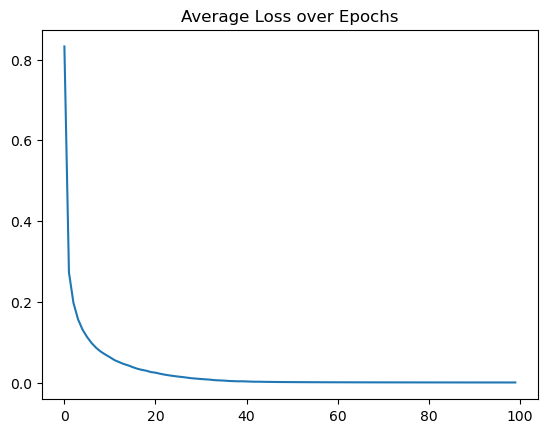

In [22]:
# Plot loss over time with title and axis labels
sns.lineplot(x=range(len(avg_losses)), y=avg_losses.cpu()).set_title(
    "Average Loss over Epochs"
)

In [29]:
# Model accuracy evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize variables to store metrics
all_labels = []
all_predictions = []

# Evaluation loop
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="macro")
recall = recall_score(all_labels, all_predictions, average="macro")
f1 = f1_score(all_labels, all_predictions, average="macro")

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

Accuracy: 0.9757, Precision: 0.9755900875241308, Recall: 0.9754696513334526, F1-Score: 0.9754898780218623


In [26]:
# Load the images from the handmade-test folder, starting with 0.png and ending with 9.png
handmade_test_images = torch.zeros((10, 28 * 28), dtype=torch.float32, device="cuda")
for i in range(10):
    with Image.open(f"handmade-test/{i}.png") as img:
        handmade_test_images[i, :] = transform(img).view(-1)

# Predict the labels for the handmade test images
handmade_test_predictions = model(handmade_test_images)
_, predicted = torch.max(handmade_test_predictions, 1)

# Print the predictions
print(predicted.cpu().numpy())

[0 1 2 3 4 5 5 7 8 9]
